In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from enum import Enum
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, classification_report, ConfusionMatrixDisplay, confusion_matrix

class VectorizerType(Enum):
    COUNT = 1
    TFID = 2
    

class DatasetType(Enum):
    REGULAR = 1
    FB_YT = 2
    REDDIT = 3
    HATECHECK = 4
    YT_REDDIT = 5
    CONV_AI = 6
    
class ReportType(Enum):
    DETAILED = 1
    BRIEF = 2
    

# Helper Methods

#### Load Dataset

In [2]:
def LoadDataset(FileName, info=False):
    df = pd.read_csv(FileName)
    if info == True:
        fig = plt.figure(figsize=(3,3))
        sns.heatmap(df.isnull(),yticklabels=False)
        df.info()
        print("\n\n")
    return df

#### Data Cleaning and Preprocessing

In [3]:
def basic_data_cleaning(df, info=False, datasetType=DatasetType.REGULAR):
    # drop rows with null values
    df = df.dropna()

    # drop unnecessary columns
    if datasetType == DatasetType.FB_YT or datasetType == DatasetType.HATECHECK or datasetType == DatasetType.YT_REDDIT or datasetType == DatasetType.CONV_AI:
        df = df.drop(columns=['labels'])
    elif datasetType == DatasetType.REDDIT:
        df = df.drop(columns=['id', 'labels'])
    else:
        df = df.drop(columns=['id','file_platform','file_language', 'file_name', 'labels'])

    #drop duplicates
    df = df.drop_duplicates('text')

    #change data type of binary labels to int
    df['binary_labels'] = df['binary_labels'].astype('int')

    #rename the column name to labels
    df = df.rename(columns={"binary_labels": "labels"})

    #see the changes made
    if info == True:
        print("Dataset Info after Data Preprocessing Step:\n")
        df.info()
    
    return df

In [4]:
def text_data_processing(df):
    #convert everything to lowercase
    df = df.lower() 
    
    #removing links
    df = re.sub(r"http\S+", "", df) 
    
    #removing usernames @...
    df = re.sub(r"\@\S+", "", df) 
    
    #removing numbers
    df = re.sub(r"[0-9]+","",df) 
    
    #removing alphanumeric words
    df = re.sub(r"\b([a-z]+[0-9]+|[0-9]+[a-z]+)[a-z0-9]*\b","",df) 
    
    #remove punctuations
    df = re.sub(r"[^\w\s]","",df) 
    
    #remove irrelevant words detected in wordcloud
    df = re.sub(r"amp","",df) 
    df = re.sub(r"rt","",df) 
    df = re.sub(r"mkr","",df) 
    #df = re.sub(r'[^A-Za-z ]', '', df)
    
    # tokenization
    df_tokens = word_tokenize(df)
    
    #removing stopwords
    filtered_df = [w for w in df_tokens if not w in stop_words]
    
    #lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmatized_df = [lemmatizer.lemmatize(w) for w in filtered_df ]
        
    return " ".join(lemmatized_df)

#### Visualization

In [5]:
def visualize_label_distribution(df):
    fig = plt.figure(figsize=(3,3))
    sns.countplot(x='labels', data = df)

    fig = plt.figure(figsize=(3,3))
    colors = ("red", "gold")
    wp = {'linewidth':2, 'edgecolor':"black"}
    tags = df['labels'].value_counts()
    explode = (0.1, 0.1)
    tags.plot(kind='pie',autopct = '%1.1f%%', shadow=True, colors = colors, startangle =90, 
         wedgeprops = wp, explode = explode, label='')
    plt.title('Label Distribution in Twitter Dataset')

In [6]:
def visualize_word_cloud(Data, Title):
    text = ' '.join([word for word in Data])
    plt.figure(figsize=(10,10), facecolor='w')
    wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(Title, fontsize = 19)
    plt.show()

#### Vectorize

In [7]:
def Vectorize(mode,minRange,maxRange):
    if mode == VectorizerType.COUNT:
        return CountVectorizer(analyzer='word', ngram_range=(minRange, maxRange))
    if mode == VectorizerType.TFID:
        return TfidfVectorizer(analyzer='word', ngram_range=(minRange, maxRange))

#### Train Test Validation Split

In [8]:
def train_validate_test_split(vectorizer, XData, YData):
    X = vectorizer.fit_transform(XData)
    Y = YData
    x, x_test, y, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
    x_train, x_validate, y_train, y_validate = train_test_split(x, y, test_size=0.1, random_state=42)
    return x_train, x_validate, x_test, y_train, y_validate, y_test

#### Model Selection

In [9]:
def get_best_model(x_train, y_train, x_validate, y_validate, params):
    bestModel = None
    bestScore = -0.0000000001
    
    # hyperparameter tuning
    for i in params:
        model = MultinomialNB(alpha=i)
        model.fit(x_train, y_train)
        y_predict = model.predict(x_validate)
        score = f1_score(y_validate, y_predict, average='macro')
        if score > bestScore:
            bestScore = score
            bestModel = model
            
    return bestModel

In [10]:
def model_selection(df):
    vectorizer = []
    vectorizer.append(Vectorize(VectorizerType.COUNT, 1, 1))
    vectorizer.append(Vectorize(VectorizerType.COUNT, 1, 2))
    vectorizer.append(Vectorize(VectorizerType.COUNT, 2, 2))
    vectorizer.append(Vectorize(VectorizerType.TFID, 1, 1))
    vectorizer.append(Vectorize(VectorizerType.TFID, 1, 2))
    vectorizer.append(Vectorize(VectorizerType.TFID, 2, 2))
    
    selected_model = None
    selected_vectorizer = None
    slected_y_test = None
    selected_y_predict = None
    score = -0.00000000001

    for i in vectorizer:
        print("============= TESTING WITH VECTORIZER ", i, " =============")
        model, f1, y_test, y_predict = GenericNaiveBayes(i, df['text'], df['labels'])
        if f1 > score:
            score = f1
            selected_model = model
            selected_vect = i
            selected_y_test = y_test
            selected_y_predict = y_predict
    print("\n\nBEST MODEL IS ", selected_model, " , ", selected_vect)
    Confusion_Matrix(selected_y_test, selected_y_predict, selected_model)

#### Naive Bayes

In [11]:
def GenericNaiveBayes(vect, df_X, df_Y):
    x_train, x_validate, x_test, y_train, y_validate, y_test = train_validate_test_split(vect, df_X, df_Y)
    params = [0.001,0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,2,3]
    model = get_best_model(x_train, y_train, x_validate, y_validate, params)
    y_predict = model.predict(x_test)
    f1 = EvaluatePerformance(y_test, y_predict)
    return model, f1, y_test, y_predict

#### Evaluation

In [12]:
def EvaluatePerformance(y_test, y_predict):
    f1 = f1_score(y_test, y_predict, average='macro')
    accuracy = accuracy_score(y_test, y_predict)
    precision = precision_score(y_test, y_predict, average='macro')
    recall = recall_score(y_test, y_predict, average='macro')

    print("F1 Score: ", f1)
    print("Accuracy: ", accuracy)
    print("Precision: ", precision)
    print("Recall: ", recall)
    return f1

In [13]:
def Confusion_Matrix(y_test, y_predict, model):
    print(classification_report(y_test, y_predict))
    style.use('classic')
    cm = confusion_matrix(y_test, y_predict, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()

#### In Domain Test

In [14]:
def in_domain_test(filename, vectorizer, alpha_val, datasetType=DatasetType.REGULAR):
    df = pd.read_csv(filename)
    
    df = basic_data_cleaning(df, False, datasetType)
    df.text = df['text'].apply(text_data_processing)
    
    X = vectorizer.fit_transform(df['text'])
    Y = df['labels']
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

    model = MultinomialNB(alpha=alpha_val)
    model.fit(x_train, y_train)
    y_predict = model.predict(x_test)

    f1 = f1_score(y_test, y_predict, average='macro')
    accuracy = accuracy_score(y_test, y_predict)
    precision = precision_score(y_test, y_predict, average='macro')
    recall = recall_score(y_test, y_predict, average='macro')

    print("F1 Score: ", f1)
    print("Accuracy: ", accuracy)
    print("Precision: ", precision)
    print("Recall: ", recall)

#### Cross Domain Test

In [15]:
def cross_domain_test(filename_train, filename_test, vectorizer, alpha_val, trainsetType=DatasetType.REGULAR, testsetType=DatasetType.REGULAR):
    df_train = pd.read_csv(filename_train)
    df_train = basic_data_cleaning(df_train, False, trainsetType)
    df_train.text = df_train['text'].apply(text_data_processing)

    df_test = pd.read_csv(filename_test)
    df_test = basic_data_cleaning(df_test, False, testsetType)
    df_test.text = df_test['text'].apply(text_data_processing)

    X_train = vectorizer.fit_transform(df_train['text'])
    Y_train = df_train['labels']
    X_test = vectorizer.transform(df_test['text'])
    Y_test = df_test['labels']

    model = MultinomialNB(alpha=alpha_val)
    model.fit(X_train, Y_train)
    y_predict = model.predict(X_test)

    f1 = f1_score(Y_test, y_predict, average='macro')
    print("F1: ", f1, "Train: ", filename_train, " Test: ", filename_test)

# Twitter Dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 337747 entries, 0 to 337746
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id             337747 non-null  int64  
 1   file_platform  337747 non-null  object 
 2   file_language  337747 non-null  object 
 3   file_name      337747 non-null  object 
 4   text           337747 non-null  object 
 5   labels         132815 non-null  object 
 6   binary_labels  132815 non-null  float64
dtypes: float64(1), int64(1), object(5)
memory usage: 18.0+ MB





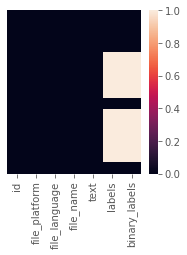

In [16]:
#load dataset
tweet_df = LoadDataset("Twitter.csv", True)

# data cleaning
tweet_df = basic_data_cleaning(tweet_df)
tweet_df.text = tweet_df['text'].apply(text_data_processing)

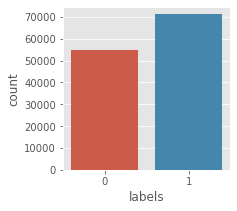

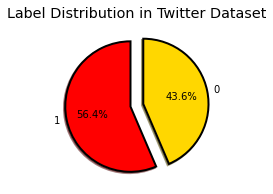

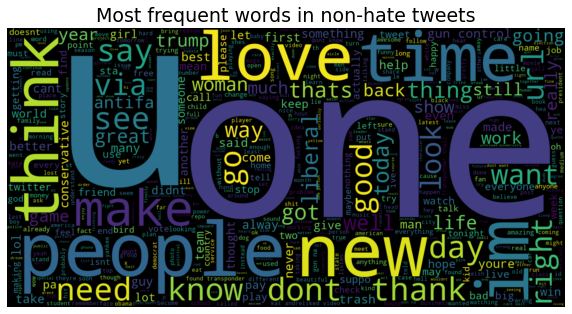

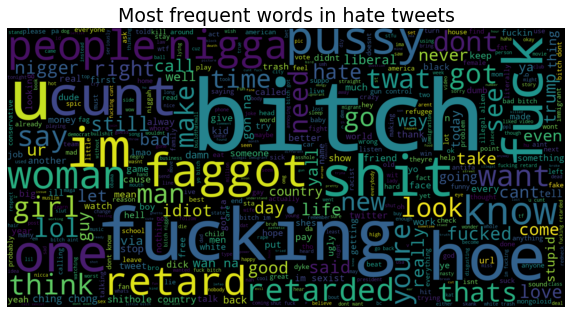

In [17]:
#visualization
visualize_label_distribution(tweet_df)

non_hate_tweets = tweet_df[tweet_df.labels == 0]
visualize_word_cloud(non_hate_tweets['text'], "Most frequent words in non-hate tweets")

hate_tweets = tweet_df[tweet_df.labels == 1]
visualize_word_cloud(hate_tweets['text'], "Most frequent words in hate tweets")

============= TESTING WITH VECTORIZER  CountVectorizer()  =============
F1 Score:  0.820334434520142
Accuracy:  0.8231092770415046
Precision:  0.8207743357503703
Recall:  0.819939961234813
============= TESTING WITH VECTORIZER  CountVectorizer(ngram_range=(1, 2))  =============
F1 Score:  0.8213500276448145
Accuracy:  0.8244186969288152
Precision:  0.8224966758444241
Recall:  0.8204483614234004
============= TESTING WITH VECTORIZER  CountVectorizer(ngram_range=(2, 2))  =============
F1 Score:  0.7530999340819697
Accuracy:  0.758273152924371
Precision:  0.7555438930956075
Recall:  0.7516966541069505
============= TESTING WITH VECTORIZER  TfidfVectorizer()  =============
F1 Score:  0.7931503096189954
Accuracy:  0.7988651694309975
Precision:  0.799802486617548
Recall:  0.7902790735708052
============= TESTING WITH VECTORIZER  TfidfVectorizer(ngram_range=(1, 2))  =============
F1 Score:  0.8055122149788672
Accuracy:  0.8092611697484327
Precision:  0.8075496786851686
Recall:  0.804132938781

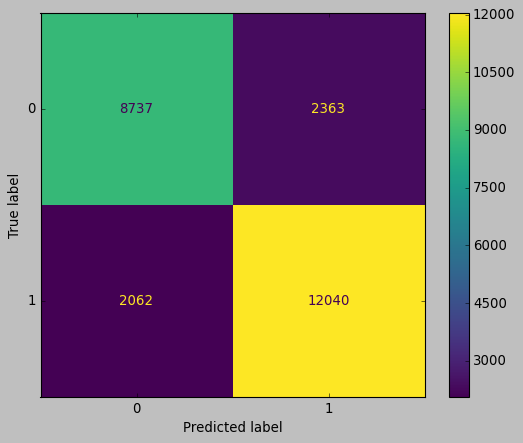

In [18]:
#selecting the best model by hyperparameter tuning and testing two feature transformation approaches
model_selection(tweet_df)

### In Domain Test (Twitter)

In [19]:
vectorizer = CountVectorizer(analyzer='word', ngram_range=(1, 2))
alpha_val = 0.8
in_domain_test("Twitter.csv", vectorizer, alpha_val)

F1 Score:  0.8245672964648167
Accuracy:  0.8274740099992064
Precision:  0.8254628052524517
Recall:  0.8238305281597014


### Cross Domain Tests (Train: Twitter)

In [20]:
vectorizer = CountVectorizer(analyzer='word', ngram_range=(1, 2))
alpha_val = 0.8

cross_domain_test("Twitter.csv", "fb_yt.csv", vectorizer, alpha_val, DatasetType.REGULAR, DatasetType.FB_YT)
cross_domain_test("Twitter.csv", "wiki.csv", vectorizer, alpha_val)
cross_domain_test("Twitter.csv", "fox.csv", vectorizer, alpha_val)
cross_domain_test("Twitter.csv", "reddit.csv", vectorizer, alpha_val, DatasetType.REGULAR, DatasetType.REDDIT)
cross_domain_test("Twitter.csv", "stormfront.csv", vectorizer, alpha_val)
cross_domain_test("Twitter.csv", "twi_fb.csv", vectorizer, alpha_val)
cross_domain_test("Twitter.csv", "HateCheck.csv", vectorizer, alpha_val, DatasetType.REGULAR, DatasetType.HATECHECK)
cross_domain_test("Twitter.csv", "yt_reddit.csv", vectorizer, alpha_val, DatasetType.REGULAR, DatasetType.YT_REDDIT)
cross_domain_test("Twitter.csv", "convAI.csv", vectorizer, alpha_val, DatasetType.REGULAR, DatasetType.CONV_AI)

F1:  0.6487618396471844 Train:  Twitter.csv  Test:  fb_yt.csv
F1:  0.7242054142009179 Train:  Twitter.csv  Test:  wiki.csv
F1:  0.5662819431051109 Train:  Twitter.csv  Test:  fox.csv
F1:  0.5168826569735161 Train:  Twitter.csv  Test:  reddit.csv
F1:  0.5234969967114212 Train:  Twitter.csv  Test:  stormfront.csv
F1:  0.5266290061664388 Train:  Twitter.csv  Test:  twi_fb.csv
F1:  0.5174151580458224 Train:  Twitter.csv  Test:  HateCheck.csv
F1:  0.5633628683288688 Train:  Twitter.csv  Test:  yt_reddit.csv
F1:  0.6326023689261988 Train:  Twitter.csv  Test:  convAI.csv


# FB-YT Dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3222 entries, 0 to 3221
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   text           3222 non-null   object
 1   labels         3222 non-null   object
 2   binary_labels  3222 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 75.6+ KB





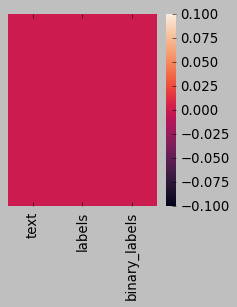

In [21]:
fb_yt_df = LoadDataset("fb_yt.csv", True)

In [22]:
fb_yt_df = basic_data_cleaning(fb_yt_df, True, DatasetType.FB_YT)

print("==================Before Processing===============\n")
print(fb_yt_df['text'].iloc[0],"\n")
print(fb_yt_df['text'].iloc[1],"\n")
print(fb_yt_df['text'].iloc[2],"\n")
print(fb_yt_df['text'].iloc[3],"\n")
print(fb_yt_df['text'].iloc[4],"\n")

fb_yt_df.text = fb_yt_df['text'].apply(text_data_processing)

print("\n\n==================After Processing===============\n")
print(fb_yt_df['text'].iloc[0],"\n")
print(fb_yt_df['text'].iloc[1],"\n")
print(fb_yt_df['text'].iloc[2],"\n")
print(fb_yt_df['text'].iloc[3],"\n")
print(fb_yt_df['text'].iloc[4],"\n")

Dataset Info after Data Preprocessing Step:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3217 entries, 0 to 3221
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    3217 non-null   object
 1   labels  3217 non-null   int32 
dtypes: int32(1), object(1)
memory usage: 62.8+ KB
==================Before Processing===============

Trump and Obama had very different first inauguration speeches. But still obama dropped some serious bombs he didn't flourish any country lol i like trump better atleast he will bomb but will not say we are flourishing this land lol 

Georgia School Principal Makes Racist Comment, Then Blames Satan I hate religious  people who blame the devil for making them say very insulting  statements.  

UNHCR: Children Are The Innocent Victims Of Europe's Refugee Crisis Whoever was in charge of sending the real Syrian refugee families over with the hundred thousands of Muslim single young men is the guilty

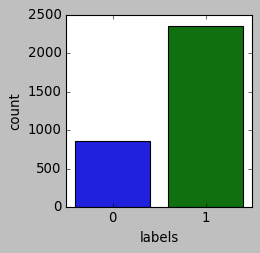

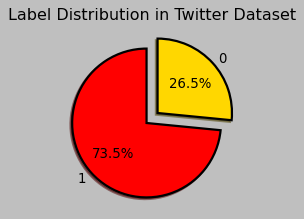

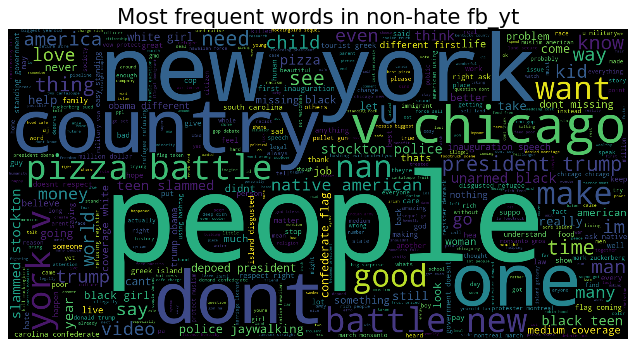

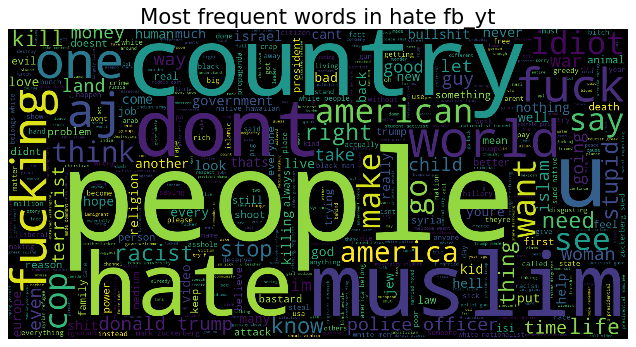

In [23]:
#visualization
visualize_label_distribution(fb_yt_df)

non_hate_fb_yt = fb_yt_df[fb_yt_df.labels == 0]
visualize_word_cloud(non_hate_fb_yt['text'], "Most frequent words in non-hate fb_yt")

hate_fb_yt = fb_yt_df[fb_yt_df.labels == 1]
visualize_word_cloud(hate_fb_yt['text'], "Most frequent words in hate fb_yt")

============= TESTING WITH VECTORIZER  CountVectorizer()  =============
F1 Score:  0.8818053537204356
Accuracy:  0.90527950310559
Precision:  0.8773726273726274
Recall:  0.8866098081023455
============= TESTING WITH VECTORIZER  CountVectorizer(ngram_range=(1, 2))  =============
F1 Score:  0.8627166297935103
Accuracy:  0.8850931677018633
Precision:  0.8478248913820601
Recall:  0.8852878464818763
============= TESTING WITH VECTORIZER  CountVectorizer(ngram_range=(2, 2))  =============
F1 Score:  0.7774125034629236
Accuracy:  0.796583850931677
Precision:  0.7714285714285715
Recall:  0.8370575692963753
============= TESTING WITH VECTORIZER  TfidfVectorizer()  =============
F1 Score:  0.8734435756925585
Accuracy:  0.90527950310559
Precision:  0.9000247565604885
Recall:  0.8543710021321962
============= TESTING WITH VECTORIZER  TfidfVectorizer(ngram_range=(1, 2))  =============
F1 Score:  0.8719851576994434
Accuracy:  0.906832298136646
Precision:  0.9162632608919559
Recall:  0.84469083155650

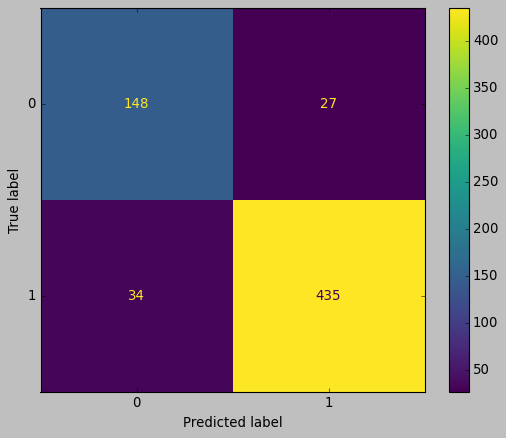

In [24]:
model_selection(fb_yt_df)

### In Domain Test (fb_yt)

In [25]:
vectorizer = CountVectorizer(analyzer='word', ngram_range=(1, 1))
alpha_val = 0.1
in_domain_test("fb_yt.csv", vectorizer, alpha_val, DatasetType.FB_YT)

F1 Score:  0.8860727232385137
Accuracy:  0.9083850931677019
Precision:  0.8804347826086956
Recall:  0.892324093816631


### Cross Domain Test (Train: fb_yt)

In [26]:
vectorizer = CountVectorizer(analyzer='word', ngram_range=(1, 1))
alpha_val = 0.1

cross_domain_test("fb_yt.csv", "Twitter.csv", vectorizer, alpha_val, DatasetType.FB_YT, DatasetType.REGULAR)
cross_domain_test("fb_yt.csv", "wiki.csv", vectorizer, alpha_val, DatasetType.FB_YT, DatasetType.REGULAR)
cross_domain_test("fb_yt.csv", "fox.csv", vectorizer, alpha_val, DatasetType.FB_YT, DatasetType.REGULAR)
cross_domain_test("fb_yt.csv", "reddit.csv", vectorizer, alpha_val, DatasetType.FB_YT, DatasetType.REDDIT)
cross_domain_test("fb_yt.csv", "stormfront.csv", vectorizer, alpha_val, DatasetType.FB_YT, DatasetType.REGULAR)
cross_domain_test("fb_yt.csv", "twi_fb.csv", vectorizer, alpha_val, DatasetType.FB_YT, DatasetType.REGULAR)
cross_domain_test("fb_yt.csv", "HateCheck.csv", vectorizer, alpha_val, DatasetType.FB_YT, DatasetType.HATECHECK)
cross_domain_test("fb_yt.csv", "yt_reddit.csv", vectorizer, alpha_val, DatasetType.FB_YT, DatasetType.YT_REDDIT)
cross_domain_test("fb_yt.csv", "convAI.csv", vectorizer, alpha_val, DatasetType.FB_YT, DatasetType.CONV_AI)

F1:  0.5719139551065043 Train:  fb_yt.csv  Test:  Twitter.csv
F1:  0.3699429186735921 Train:  fb_yt.csv  Test:  wiki.csv
F1:  0.4007181677018634 Train:  fb_yt.csv  Test:  fox.csv
F1:  0.35233165345350725 Train:  fb_yt.csv  Test:  reddit.csv
F1:  0.3250586156421309 Train:  fb_yt.csv  Test:  stormfront.csv
F1:  0.3785589844112195 Train:  fb_yt.csv  Test:  twi_fb.csv
F1:  0.5179379725517491 Train:  fb_yt.csv  Test:  HateCheck.csv
F1:  0.44230855805159147 Train:  fb_yt.csv  Test:  yt_reddit.csv
F1:  0.4290210722859429 Train:  fb_yt.csv  Test:  convAI.csv


# Wiki Dataset

In [ ]:
wiki_df = LoadDataset("wiki.csv", True)

In [ ]:
wiki_df = basic_data_cleaning(wiki_df, True)

In [ ]:
print("==================Before Processing===============\n")
print(wiki_df['text'].iloc[0],"\n")
print(wiki_df['text'].iloc[1],"\n")
print(wiki_df['text'].iloc[2],"\n")
print(wiki_df['text'].iloc[3],"\n")
print(wiki_df['text'].iloc[4],"\n")

wiki_df.text = wiki_df['text'].apply(text_data_processing)

print("\n\n==================After Processing===============\n")
print(wiki_df['text'].iloc[0],"\n")
print(wiki_df['text'].iloc[1],"\n")
print(wiki_df['text'].iloc[2],"\n")
print(wiki_df['text'].iloc[3],"\n")
print(wiki_df['text'].iloc[4],"\n")

In [ ]:
#visualization
visualize_label_distribution(wiki_df)

non_hate_wiki = wiki_df[wiki_df.labels == 0]
visualize_word_cloud(non_hate_wiki['text'], "Most frequent words in non-hate wiki")

hate_wiki = wiki_df[wiki_df.labels == 1]
visualize_word_cloud(hate_wiki['text'], "Most frequent words in hate wiki")

In [ ]:
model_selection(wiki_df)

### In Domain Test

In [ ]:
vectorizer = CountVectorizer(analyzer='word', ngram_range=(1, 1))
alpha_val = 0.3
in_domain_test("wiki.csv", vectorizer, alpha_val)

### Cross Domain Test

In [ ]:
vectorizer = CountVectorizer(analyzer='word', ngram_range=(1, 1))
alpha_val = 0.3

cross_domain_test("wiki.csv", "fb_yt.csv", vectorizer, alpha_val, DatasetType.REGULAR, DatasetType.FB_YT)
cross_domain_test("wiki.csv", "Twitter.csv", vectorizer, alpha_val)
cross_domain_test("wiki.csv", "fox.csv", vectorizer, alpha_val)
#cross_domain_test("wiki.csv", DatasetType.EXCEPTION, "reddit.csv", DatasetType.REGULAR, vectorizer, alpha_val)
cross_domain_test("wiki.csv", "stormfront.csv", vectorizer, alpha_val)
cross_domain_test("wiki.csv", "twi_fb.csv", vectorizer, alpha_val)
#cross_domain_test("wiki.csv", DatasetType.EXCEPTION, "HateCheck.csv", DatasetType.REGULAR, vectorizer, alpha_val)
#cross_domain_test("wiki.csv", DatasetType.EXCEPTION, "yt_reddit.csv", DatasetType.REGULAR, vectorizer, alpha_val)
#cross_domain_test("wiki.csv", DatasetType.EXCEPTION, "convAI.csv", DatasetType.REGULAR, vectorizer, alpha_val)

# Fox Dataset

In [ ]:
fox_df = LoadDataset("fox.csv", True)

In [ ]:
fox_df = basic_data_cleaning(fox_df, True)

In [ ]:
print("==================Before Processing===============\n")
print(fox_df['text'].iloc[0],"\n")
print(fox_df['text'].iloc[1],"\n")
print(fox_df['text'].iloc[2],"\n")
print(fox_df['text'].iloc[3],"\n")
print(fox_df['text'].iloc[4],"\n")

fox_df.text = fox_df['text'].apply(text_data_processing)

print("\n\n==================After Processing===============\n")
print(fox_df['text'].iloc[0],"\n")
print(fox_df['text'].iloc[1],"\n")
print(fox_df['text'].iloc[2],"\n")
print(fox_df['text'].iloc[3],"\n")
print(fox_df['text'].iloc[4],"\n")

In [ ]:
#visualization
visualize_label_distribution(fox_df)

non_hate_fox = fox_df[fox_df.labels == 0]
visualize_word_cloud(non_hate_fox['text'], "Most frequent words in non-hate fox")

hate_fox = fox_df[fox_df.labels == 1]
visualize_word_cloud(hate_fox['text'], "Most frequent words in hate fox")

In [ ]:
model_selection(fox_df)

### In Domain Test

In [ ]:
vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1,2))
alpha_val = 0.1
in_domain_test("fox.csv", vectorizer, alpha_val)

### Cross Domain Test

In [ ]:
vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1,2))
alpha_val = 0.1

cross_domain_test("fox.csv", "fb_yt.csv", vectorizer, alpha_val, DatasetType.REGULAR, DatasetType.FB_YT)
cross_domain_test("fox.csv", "Twitter.csv", vectorizer, alpha_val)
cross_domain_test("fox.csv", "wiki.csv", vectorizer, alpha_val)
#cross_domain_test("fox.csv", DatasetType.EXCEPTION, "reddit.csv", DatasetType.REGULAR, vectorizer, alpha_val)
cross_domain_test("fox.csv", "stormfront.csv", vectorizer, alpha_val)
cross_domain_test("fox.csv", "twi_fb.csv", vectorizer, alpha_val)
#cross_domain_test("wiki.csv", DatasetType.EXCEPTION, "HateCheck.csv", DatasetType.REGULAR, vectorizer, alpha_val)
#cross_domain_test("wiki.csv", DatasetType.EXCEPTION, "yt_reddit.csv", DatasetType.REGULAR, vectorizer, alpha_val)
#cross_domain_test("wiki.csv", DatasetType.EXCEPTION, "convAI.csv", DatasetType.REGULAR, vectorizer, alpha_val)

# Reddit Dataset

In [ ]:
reddit_df = LoadDataset("reddit.csv", True)

In [ ]:
reddit_df = basic_data_cleaning(reddit_df, True, DatasetType.REDDIT)

In [ ]:
print("==================Before Processing===============\n")
print(reddit_df['text'].iloc[0],"\n")
print(reddit_df['text'].iloc[1],"\n")
print(reddit_df['text'].iloc[2],"\n")
print(reddit_df['text'].iloc[3],"\n")
print(reddit_df['text'].iloc[4],"\n")

reddit_df.text = reddit_df['text'].apply(text_data_processing)

print("\n\n==================After Processing===============\n")
print(reddit_df['text'].iloc[0],"\n")
print(reddit_df['text'].iloc[1],"\n")
print(reddit_df['text'].iloc[2],"\n")
print(reddit_df['text'].iloc[3],"\n")
print(reddit_df['text'].iloc[4],"\n")

In [ ]:
#visualization
visualize_label_distribution(reddit_df)

non_hate_reddit = reddit_df[reddit_df.labels == 0]
visualize_word_cloud(non_hate_reddit['text'], "Most frequent words in non-hate reddit")

hate_reddit = reddit_df[reddit_df.labels == 1]
visualize_word_cloud(hate_reddit['text'], "Most frequent words in hate reddit")

In [ ]:
model_selection(reddit_df)

### In Domain Test

In [ ]:
vectorizer = CountVectorizer(analyzer='word', ngram_range=(1, 2))
alpha_val = 0.7
in_domain_test("reddit.csv", vectorizer, alpha_val, DatasetType.REDDIT)

### Cross Domain Test

In [ ]:
vectorizer = CountVectorizer(analyzer='word', ngram_range=(1, 2))
alpha_val = 0.7

cross_domain_test("reddit.csv", "fb_yt.csv", vectorizer, alpha_val, DatasetType.REDDIT, DatasetType.FB_YT)
cross_domain_test("reddit.csv", "Twitter.csv", vectorizer, alpha_val, DatasetType.REDDIT, DatasetType.REGULAR)
cross_domain_test("reddit.csv", "wiki.csv", vectorizer, alpha_val, DatasetType.REDDIT, DatasetType.REGULAR)
cross_domain_test("reddit.csv", "fox.csv", vectorizer, alpha_val, DatasetType.REDDIT, DatasetType.REGULAR)
#cross_domain_test("reddit.csv", "reddit.csv", vectorizer, alpha_val, DatasetType.REDDIT, DatasetType.REGULAR)
cross_domain_test("reddit.csv", "stormfront.csv", vectorizer, alpha_val, DatasetType.REDDIT, DatasetType.REGULAR)
cross_domain_test("reddit.csv", "twi_fb.csv", vectorizer, alpha_val, DatasetType.REDDIT, DatasetType.REGULAR)
#cross_domain_test("reddit.csv", "HateCheck.csv", vectorizer, alpha_val, DatasetType.REDDIT, DatasetType.REGULAR)
#cross_domain_test("reddit.csv", "yt_reddit.csv", vectorizer, alpha_val, DatasetType.REDDIT, DatasetType.REGULAR)
#cross_domain_test("reddit.csv", "convAI.csv", vectorizer, alpha_val, DatasetType.REDDIT, DatasetType.REGULAR)

# Stormfront Dataset

In [ ]:
stormfront_df = LoadDataset("stormfront.csv", True)

In [ ]:
stormfront_df = basic_data_cleaning(stormfront_df, True)

In [ ]:
print("==================Before Processing===============\n")
print(stormfront_df['text'].iloc[0],"\n")
print(stormfront_df['text'].iloc[1],"\n")
print(stormfront_df['text'].iloc[2],"\n")
print(stormfront_df['text'].iloc[3],"\n")
print(stormfront_df['text'].iloc[4],"\n")

stormfront_df.text = stormfront_df['text'].apply(text_data_processing)

print("==================After Processing===============\n")
print(stormfront_df['text'].iloc[0],"\n")
print(stormfront_df['text'].iloc[1],"\n")
print(stormfront_df['text'].iloc[2],"\n")
print(stormfront_df['text'].iloc[3],"\n")
print(stormfront_df['text'].iloc[4],"\n")

In [ ]:
#visualization
visualize_label_distribution(stormfront_df)

non_hate_stormfront = stormfront_df[stormfront_df.labels == 0]
visualize_word_cloud(non_hate_stormfront['text'], "Most frequent words in non-hate stormfront")

hate_stormfront = stormfront_df[stormfront_df.labels == 1]
visualize_word_cloud(hate_stormfront['text'], "Most frequent words in hate stormfront")

In [ ]:
model_selection(stormfront_df)

### In Domain Test

In [ ]:
vectorizer = CountVectorizer(analyzer='word', ngram_range=(1, 1))
alpha_val = 0.01
in_domain_test("stormfront.csv", vectorizer, alpha_val)

### Cross Domain Test

In [ ]:
vectorizer = CountVectorizer(analyzer='word', ngram_range=(1, 1))
alpha_val = 0.01

cross_domain_test("stormfront.csv", "fb_yt.csv", vectorizer, alpha_val, DatasetType.REGULAR, DatasetType.FB_YT)
cross_domain_test("stormfront.csv", "Twitter.csv", vectorizer, alpha_val)
cross_domain_test("stormfront.csv", "wiki.csv", vectorizer, alpha_val)
cross_domain_test("stormfront.csv", "fox.csv", vectorizer, alpha_val)
cross_domain_test("stormfront.csv", "reddit.csv", vectorizer, alpha_val, DatasetType.REGULAR, DatasetType.REDDIT)
cross_domain_test("stormfront.csv", "twi_fb.csv", vectorizer, alpha_val)
#cross_domain_test("stormfront.csv", DatasetType.EXCEPTION, "HateCheck.csv", DatasetType.REGULAR, vectorizer, alpha_val)
#cross_domain_test("stormfront.csv", DatasetType.EXCEPTION, "yt_reddit.csv", DatasetType.REGULAR, vectorizer, alpha_val)
#cross_domain_test("stormfront.csv", DatasetType.EXCEPTION, "convAI.csv", DatasetType.REGULAR, vectorizer, alpha_val)

# TWI_FB DATASET

In [ ]:
twi_fb_df = LoadDataset("twi_fb.csv", True)

In [ ]:
twi_fb_df = basic_data_cleaning(twi_fb_df, True)

In [ ]:
print("==================Before Processing===============\n")
print(twi_fb_df['text'].iloc[0],"\n")
print(twi_fb_df['text'].iloc[1],"\n")
print(twi_fb_df['text'].iloc[2],"\n")
print(twi_fb_df['text'].iloc[3],"\n")
print(twi_fb_df['text'].iloc[4],"\n")

twi_fb_df.text = twi_fb_df['text'].apply(text_data_processing)

print("==================After Processing===============\n")
print(twi_fb_df['text'].iloc[0],"\n")
print(twi_fb_df['text'].iloc[1],"\n")
print(twi_fb_df['text'].iloc[2],"\n")
print(twi_fb_df['text'].iloc[3],"\n")
print(twi_fb_df['text'].iloc[4],"\n")

In [ ]:
#visualization
visualize_label_distribution(twi_fb_df)

non_hate_twi_fb = twi_fb_df[twi_fb_df.labels == 0]
visualize_word_cloud(non_hate_twi_fb['text'], "Most frequent words in non-hate twi_fb")

hate_twi_fb = twi_fb_df[twi_fb_df.labels == 1]
visualize_word_cloud(hate_twi_fb['text'], "Most frequent words in hate twi_fb")